In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score, recall_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from livelossplot import PlotLossesKeras
import optuna
from optuna.samplers import TPESampler

from mypackage import dir

# Environment variables
modality = 'p'
project = 'australian'
data = dir.make_dir_line(modality, project) 
processed = data('processed')
models = data('models')

# Función para cargar datos
def cargar_datos(table_name: str) -> pd.DataFrame:
    df = pd.read_parquet(processed / f'{table_name}.parquet.gzip')
    print(f'Loaded table: {table_name}')
    return df

# Función para cargar los datos en la base de datos
def cargar_en_db(df: pd.DataFrame, table_name: str) -> None:
    df.to_parquet(models/f'{table_name}.parquet.gzip', compression='gzip')
    print(f'Saved table: {table_name}')

smote = SMOTE(random_state=42)

In [4]:
rfm = cargar_datos('rfm')
rfm['target'] = np.where(rfm['recency'] <= 90, 1, 0)
rfm = rfm.loc[:,['live_purches', 'tenure', 'monetary', 'target']]  #'recency', 'frequency', 

X = rfm.drop(["target"], axis=1)  # Características
y = rfm["target"]  # Target

# Dividir los datos
X, y = smote.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rfm.head()

Loaded table: rfm


,live_purches,tenure,monetary,target
0,1478,1246,1076.8,0
1,1480,1397,1835.2,1
2,1477,1387,1196.8,1
3,1484,1476,1808.0,1
4,1309,1307,1128.0,1


In [5]:
rfm['target'].value_counts()

target
1    477
0    158
Name: count, dtype: int64

In [6]:
# Crear preprocesamiento (MinMaxScaler y StandardScaler)
preprocessor = ColumnTransformer(
    transformers=[
        ("minmax", MinMaxScaler(), slice(0, X.shape[1])),  # Escalado MinMax para todas las columnas
        ("std_scaler", StandardScaler(), slice(0, X.shape[1])),  # Estandarización
    ],
    remainder="passthrough"
)

# Crear modelos de clustering
lr = LogisticRegressionCV(cv=10, random_state=42)

# Pipelines
pipeline_lr = Pipeline(steps=[
    ('preprocessor', MinMaxScaler()),  # Escalado MinMax
    ('preprocessor2', StandardScaler()),  # Estandarización
    ('lr', lr)
])

# Entrenamiento
pipeline_lr.fit(X_train, y_train)

Pipeline(steps=[('preprocessor', MinMaxScaler()),
                ('preprocessor2', StandardScaler()),
                ('lr', LogisticRegressionCV(cv=10, random_state=42))])

In [72]:
# Guardar el pipeline
with open(models/'pipeline_lr.pkl', 'wb') as f:
    pickle.dump(pipeline_lr, f)

In [26]:
y_pred = pipeline_lr.predict(X_test)

# # Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# # Evaluar el modelo
recall = recall_score(y_test, y_pred)
print("Recall:", recall)

Accuracy: 0.9947643979057592
Recall: 0.9897959183673469


In [27]:
y_pred

array([1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1])

In [37]:
y_pred = pipeline_lr.predict_proba(X_test)
vl = y_pred[:,1]
numeros_decimales = np.round(vl, 3)
print(numeros_decimales)

[1.    0.    0.213 0.053 0.558 0.991 0.    0.929 1.    0.    0.004 1.
 0.972 0.    0.    0.    0.    0.    1.    1.    1.    0.    1.    0.993
 0.041 0.    1.    0.    0.938 1.    0.    1.    1.    1.    0.995 1.
 0.    0.823 1.    0.    1.    1.    1.    1.    1.    0.    1.    1.
 1.    0.015 0.995 1.    1.    0.    0.    0.    0.    1.    0.006 1.
 0.967 1.    0.    1.    1.    0.    0.    0.    0.    1.    0.    1.
 1.    0.843 0.    0.    0.    0.003 0.    0.    0.    0.    1.    0.002
 0.    0.989 0.927 1.    1.    1.    0.    1.    1.    1.    0.765 0.
 1.    0.092 0.    0.    0.107 0.    1.    1.    1.    0.    0.018 0.927
 0.964 0.005 1.    0.    1.    0.206 0.928 0.    0.    0.    1.    1.
 1.    0.    0.    0.    0.    0.    1.    1.    1.    0.    0.116 0.
 1.    0.    1.    0.    0.    0.    1.    0.    0.    1.    0.    0.397
 0.    1.    1.    0.019 0.219 0.    0.    0.994 0.    1.    1.    0.
 0.    0.325 1.    1.    0.    0.    1.    1.    0.    0.947 1.    0.
 1.    1

In [74]:
prediction = pipeline_lr.predict_proba([[1462, 1298, 1134]])
prediction = prediction[:,1]
numeros_decimales = np.round(prediction, 3)
print(numeros_decimales)

[0.]


C:\Users\Administrator\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [73]:
with open(models/'pipeline_lr.pkl', 'rb') as f:
    loaded_pipeline = pickle.load(f)

In [75]:
prediction = loaded_pipeline.predict_proba([[1462, 1298, 1134]])
prediction = prediction[:,1]
numeros_decimales = np.round(prediction, 3)
print(numeros_decimales)

[0.]


C:\Users\Administrator\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [44]:
rfm = cargar_datos('rfm')
rfm['target'] = np.where(rfm['recency'] <= 90, 1, 0)
rfm = rfm.loc[:,['live_purches', 'tenure', 'monetary', 'target']]  #'recency', 'frequency', 

X = rfm.drop(["target"], axis=1)  # Características
y = rfm["target"]  # Target

# Dividir los datos
X, y = smote.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rfm.head()

Loaded table: rfm


,live_purches,tenure,monetary,target
0,1478,1246,1076.8,0
1,1480,1397,1835.2,1
2,1477,1387,1196.8,1
3,1484,1476,1808.0,1
4,1309,1307,1128.0,1


In [45]:
scaler = MinMaxScaler()
scaler2 = StandardScaler()
X = scaler.fit_transform(X)
X = scaler2.fit_transform(X)

In [46]:
# Dividir los datos
X, y = smote.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model = Sequential()
model.add(Dense(5,activation='relu', input_shape=(X.shape[1],)))
model.add(Dense(1,activation='sigmoid'))
model.summary()

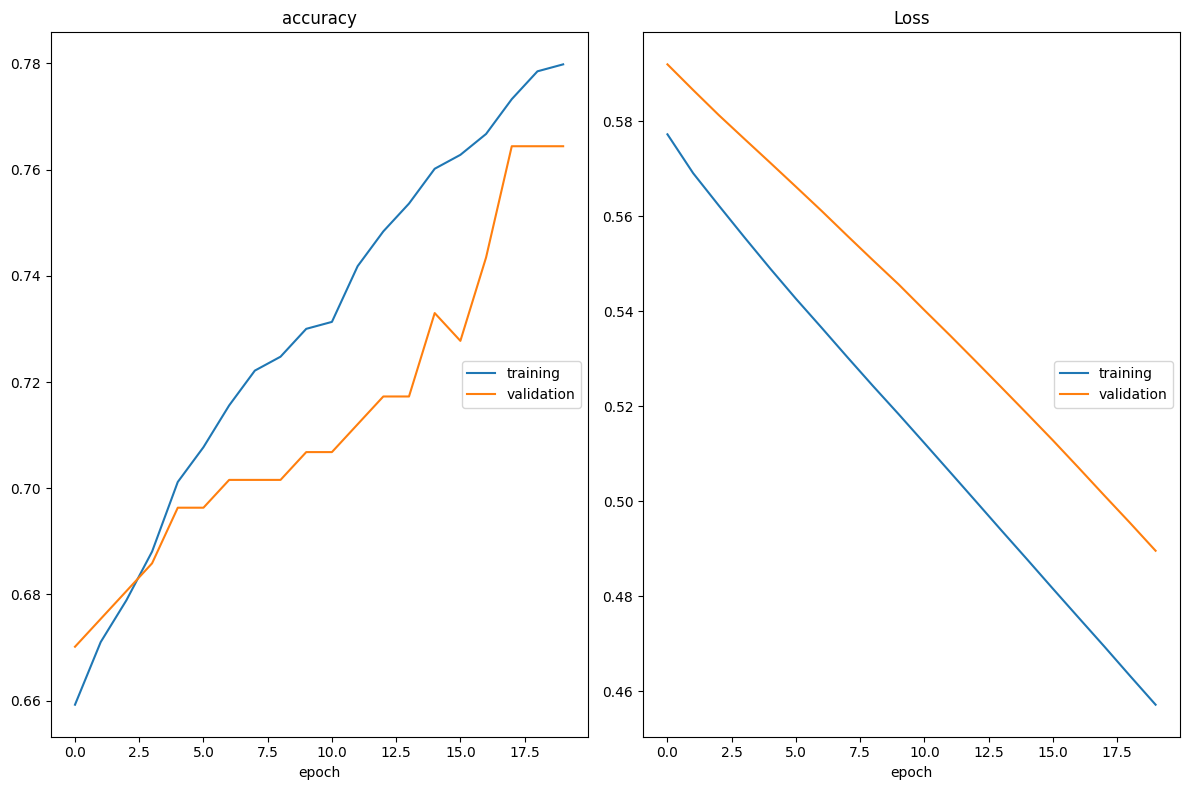

accuracy
	training         	 (min:    0.659, max:    0.780, cur:    0.780)
	validation       	 (min:    0.670, max:    0.764, cur:    0.764)
Loss
	training         	 (min:    0.457, max:    0.577, cur:    0.457)
	validation       	 (min:    0.490, max:    0.592, cur:    0.490)
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.7648 - loss: 0.4707 - val_accuracy: 0.7644 - val_loss: 0.4896


In [ ]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, 
          validation_data=(X_test, y_test),
          epochs=20, batch_size=64,
          callbacks=[PlotLossesKeras()])

In [ ]:
# Define la función objetivo
def objective(trial):
    # Hiperparámetro a optimizar
    units = trial.suggest_int('units', 5, 20)
    # dropout_rate = trial.suggest_uniform('dropout_rate', 0.2, 0.6)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-2)
    epochs = trial.suggest_int('epochs', 10, 100)
    
    # Inicializa el modelo con el hiperparámetro actual
    model = Sequential()
    model.add(Dense(units, activation='relu', input_dim=X_train.shape[1]))
    # model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(loss='binary_crossentropy', 
                  metrics=['accuracy'], 
                  optimizer=Adam(learning_rate=learning_rate))

    # Entrena el modelos
    history = model.fit(X_train, y_train,
                        validation_data=(X_test, y_test),
                        epochs=epochs,
                        batch_size=32,  # Ajustar el tamaño de lote si es necesario
                        verbose=True,
                        callbacks=[PlotLossesKeras()])

    # Obtén el AUC en el conjunto de validación
    val_auc = history.history['val_accuracy'][-1]
    return val_auc

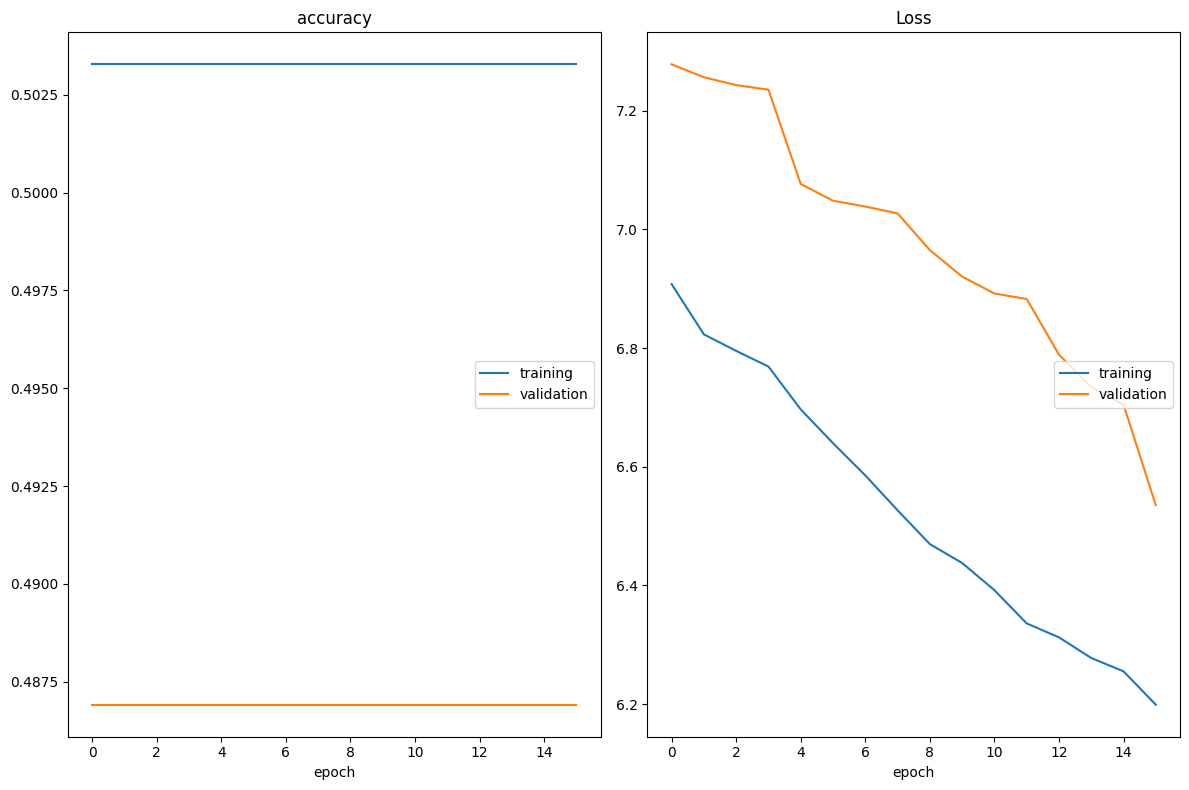

accuracy
	training         	 (min:    0.503, max:    0.503, cur:    0.503)
	validation       	 (min:    0.487, max:    0.487, cur:    0.487)
Loss
	training         	 (min:    6.199, max:    6.908, cur:    6.199)
	validation       	 (min:    6.535, max:    7.278, cur:    6.535)
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5054 - loss: 6.1849 - val_accuracy: 0.4869 - val_loss: 6.5353


[I 2024-12-11 09:54:22,974] Trial 9 finished with value: 0.48691099882125854 and parameters: {'units': 6, 'dropout_rate': 0.20321569432054007, 'learning_rate': 1.783181674723392e-05, 'epochs': 16}. Best is trial 1 with value: 0.22513088583946228.


In [58]:
# Configura el estudio
study = optuna.create_study(sampler=TPESampler(), 
                            pruner=optuna.pruners.HyperbandPruner(max_resource="auto"),
                            direction='minimize') 
study.optimize(objective, n_trials=10)

In [64]:
# Mejores hiperparámetros
print("Mejor penalizer_coef:", study.best_params)
print("Mejor valor de la función objetivo:", study.best_value)

Mejor penalizer_coef: {'units': 7, 'dropout_rate': 0.5024351943196769, 'learning_rate': 0.00015091446740391585, 'epochs': 100}
Mejor valor de la función objetivo: 0.22513088583946228


In [65]:
df_study = study.trials_dataframe(attrs=("number", "value", "params", "state"))
df_study = df_study.sort_values(by=['value'], ascending=True)
# df_study.to_csv(f'{study}.csv', encoding = 'utf-8-sig', index = False)
df_study.head(10)

,number,value,params_dropout_rate,params_epochs,params_learning_rate,params_units,state
1,1,0.225131,0.502435,100,0.000151,7,COMPLETE
8,8,0.486911,0.270745,16,0.001461,7,COMPLETE
9,9,0.486911,0.203216,16,0.000018,6,COMPLETE
0,0,0.507853,0.270324,87,0.000001,18,COMPLETE
7,7,0.565445,0.406060,91,0.000002,18,COMPLETE
2,2,0.984293,0.450464,66,0.002811,16,COMPLETE
5,5,0.984293,0.430808,62,0.001117,15,COMPLETE
6,6,0.989529,0.448405,48,0.001698,16,COMPLETE
3,3,0.994764,0.396657,56,0.004954,16,COMPLETE
4,4,0.994764,0.236642,41,0.003963,16,COMPLETE


In [66]:
model = Sequential()
model.add(Dense(study.best_params['units'],activation='relu', input_shape=(X.shape[1],)))
model.add(Dense(1,activation='sigmoid'))
model.summary()

C:\Users\Administrator\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_26 (Dense)                │ (None, 7)              │            28 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │             8 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36 (144.00 B)

 Trainable params: 36 (144.00 B)

 Non-trainable params: 0 (0.00 B)

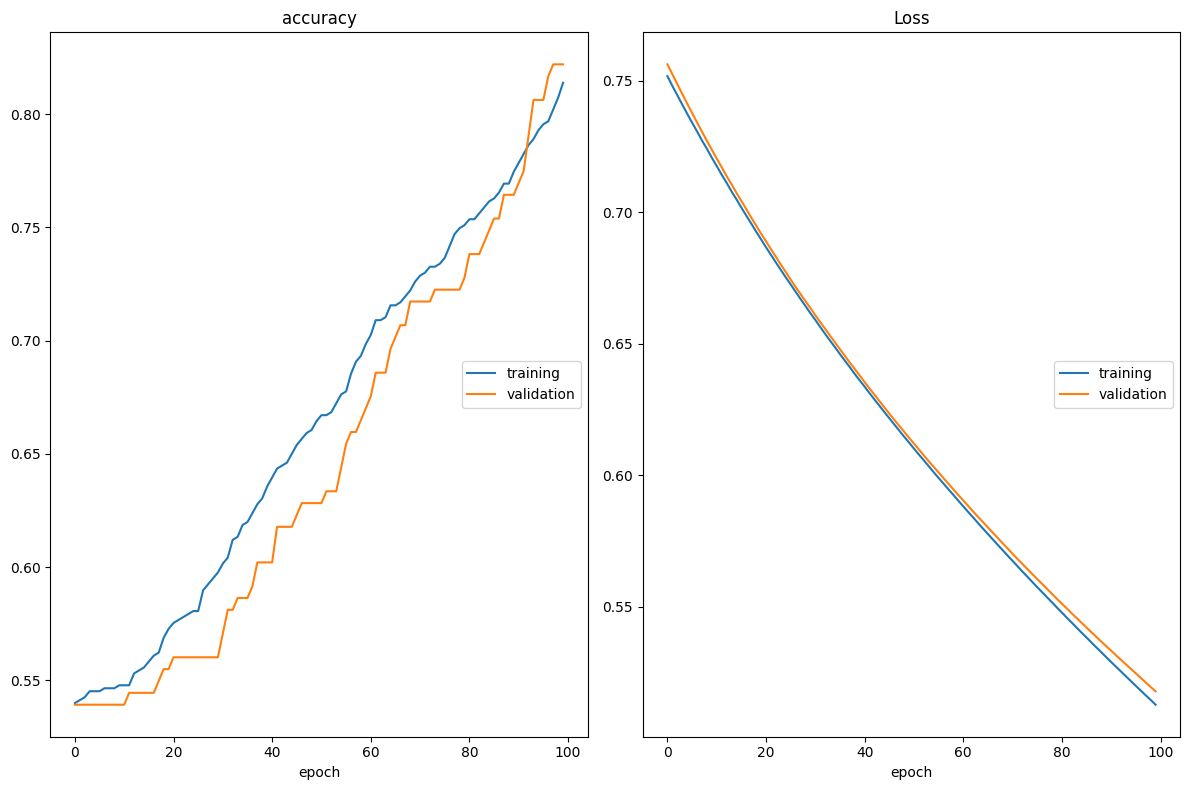

accuracy
	training         	 (min:    0.540, max:    0.814, cur:    0.814)
	validation       	 (min:    0.539, max:    0.822, cur:    0.822)
Loss
	training         	 (min:    0.513, max:    0.752, cur:    0.513)
	validation       	 (min:    0.518, max:    0.756, cur:    0.518)
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8261 - loss: 0.4984 - val_accuracy: 0.8220 - val_loss: 0.5179


In [67]:
model.compile(optimizer=Adam(learning_rate=study.best_params['learning_rate']),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, 
          validation_data=(X_test, y_test),
          epochs=study.best_params['epochs'], batch_size=64,
          callbacks=[PlotLossesKeras()])